## Rejection Sampling - Code Recipe

[Original repository on GitHub](https://github.com/Hvass-Labs/Code-Recipes)

Original author is [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

## Introduction

Generate random numbers using Rejection Sampling which works for most Probability Density Functions (PDF).

## Google Colab

In [1]:
# Is this running in Google Colab?
if 'google.colab' in str(get_ipython()):
    # Install all the required Python packages.
    %pip install numpy matplotlib

## Imports

In [2]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

## Config

In [3]:
# Plot size.
plt.rcParams["figure.figsize"] = (20,5)

## Function

In [4]:
def rejection_sampling(rng, pdf_points, pdf_values, size, max_iter=10):
    """
    Generate random samples from the given Probability Density Function (PDF)
    using Rejection Sampling.
    
    :param rng:
        Instance of `numpy.random.default_rng`.

    :param pdf_points:
        PDF points on the x-axis.
    
    :param pdf_values:
        PDF values on the y-axis. These will be linearly interpolated.
    
    :param size:
        Int for number of samples to draw.
        Fewer samples may be drawn if `max_iter` is reached.

    :param max_iter:
        Int for max number of iterations before aborting for-loop. Most
        PDFs will only need a small number of iterations, but very sparse
        PDFs could potentially go into a near-infinite sampling loop.

    :return:
        Array with random samples from given PDF.
        Elements can be `np.nan` if `max_iter` was reached.
    """
    # Convert to NumPy array if necessary.
    pdf_points = np.asarray(pdf_points)

    # Copy and scale the PDF values so the max value is 1. They don't have
    # to sum to 1, because we are only interested in their relative magnitudes,
    # and when the PDF values are larger, the random sampling is much faster.
    # To see this, consider a PDF with 10k values that are all identical.
    # If they have to sum to one, each PDF value would be 1/10k. But this would
    # mean that each sample only has 1/10k chance of being accepted, so we
    # would need to draw 10k as many samples as we really need. But we would
    # get the exact same distribution for the random samples, if all the PDF
    # values were equal to 1 instead of 1/10k, and we would accept all the
    # uniform random samples instead of only one sample for every 10k samples.
    pdf_values = np.copy(pdf_values)
    pdf_values /= pdf_values.max()

    # Init master array for saving the random samples.
    samples = np.full(shape=size, fill_value=np.nan)

    # Number of random samples accepted so far.
    num_samples = 0

    # Scaling factor for the sample-size.
    sample_size_scaler = 1.0

    # Low / high boundaries for the PDF.
    lo = pdf_points.min()
    hi = pdf_points.max()

    for i in range(max_iter):
        # Sample-size is the number of remaining random samples we need,
        # adjusted for the expected number of samples that will be accepted,
        # as well as a small boosting factor to try and ensure we get enough.
        sample_size = math.ceil((size - num_samples) * sample_size_scaler * 1.005)

        # Random uniform samples from range of PDF values.
        x = rng.uniform(lo, hi, size=sample_size)
        
        # Interpolated PDF values for the random samples.
        prob = np.interp(x=x, xp=pdf_points, fp=pdf_values)

        # Accept the random samples according to their probability.
        p = rng.uniform(0.0, 1.0, size=sample_size)
        samples_accepted = x[p < prob]

        # Number of accepted samples.
        num_accept = len(samples_accepted)

        # Are any of the samples accepted?
        if num_accept > 0:
            # Update sample-size scaler using the number of accepted samples.
            sample_size_scaler = sample_size / num_accept
            
            # Number of samples used.
            num_used = min(size - num_samples, num_accept)

            # Save the samples in the master array.
            samples[num_samples:num_samples+num_used] = \
                samples_accepted[:num_used]

            # Update number of samples accepted so far.
            num_samples += num_used

        # Break out of for-loop?
        if num_samples >= size or i >= max_iter:
            break

    return samples

## Test

In [5]:
# Random Number Generator (RNG).
rng = np.random.default_rng(seed=1234)

# Sample size.
size = 100000

# PDF points on the x-axis.
pdf_points = np.array([1, 1.5, 2, 2.1, 2.4, 2.5, 3, 3.01, 3.02])

# PDF values on the y-axis. Normalized so they sum to 1.
pdf_values = np.array([0.7, 0.5, 1.0, 0.0, 0.0, 0.5, 0.0, 1.0, 0.0])
pdf_values /= pdf_values.sum()

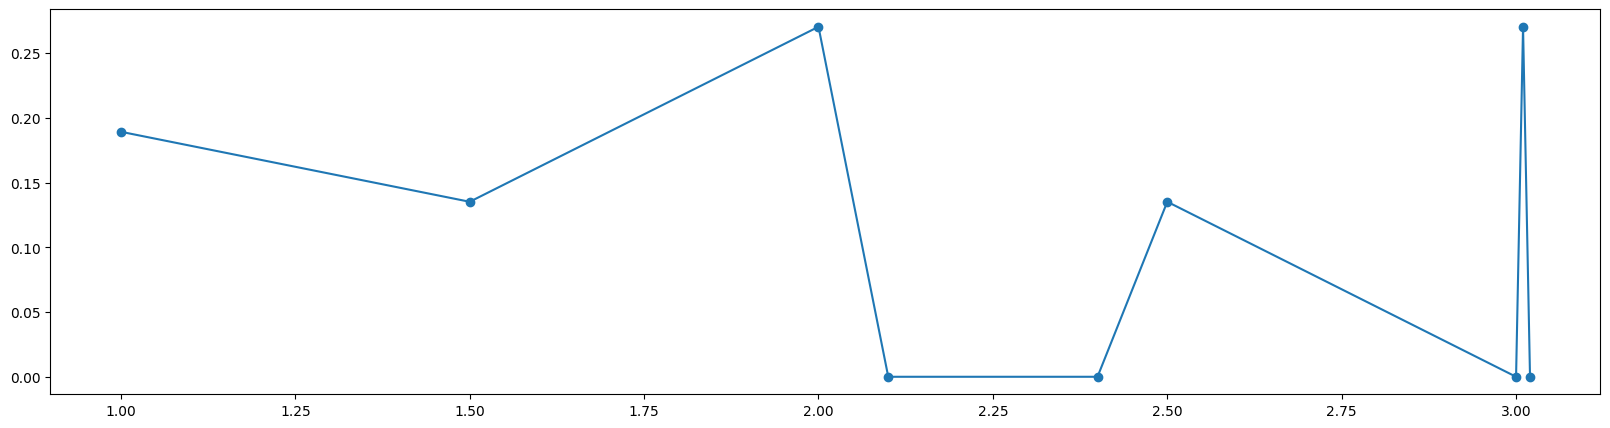

In [6]:
# Plot the PDF.
plt.plot(pdf_points, pdf_values);
plt.scatter(pdf_points, pdf_values);

In [7]:
# Generate random samples from our PDF.
samples = rejection_sampling(rng=rng, pdf_points=pdf_points,
                             pdf_values=pdf_values, size=size)

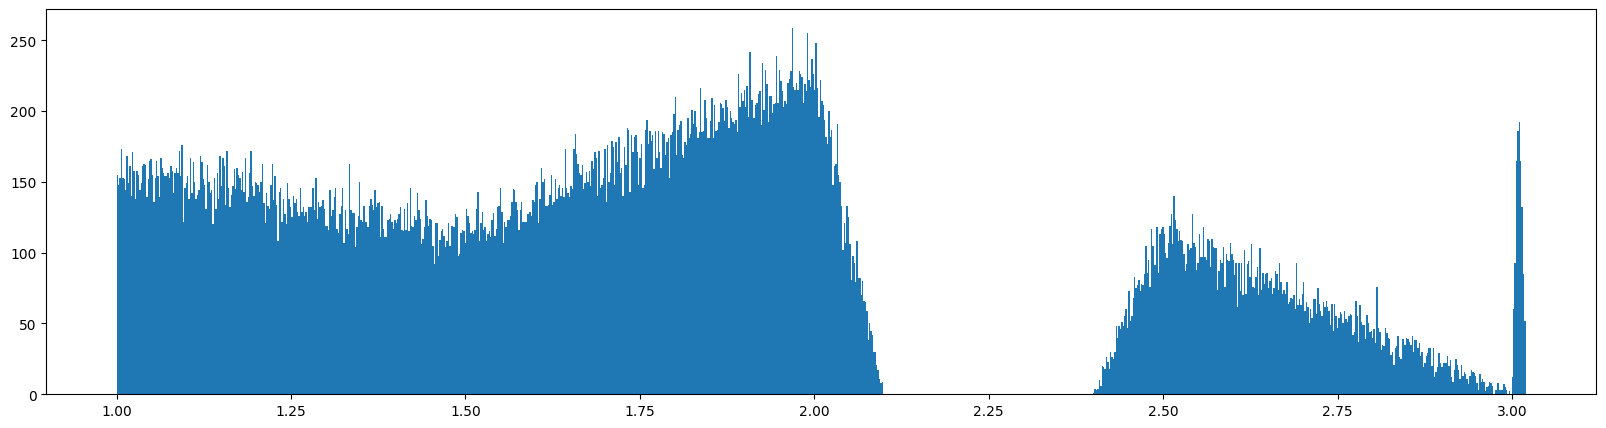

In [8]:
# Plot histogram of the samples.
plt.hist(samples, bins=1000);

## Time Usage

In [10]:
%%timeit
rejection_sampling(rng=rng, pdf_points=pdf_points, pdf_values=pdf_values, size=size)

8.68 ms ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## License (MIT)

This is published under the [MIT License](https://github.com/Hvass-Labs/Code-Recipes/blob/main/LICENSE) which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/Hvass-Labs/Code-Recipes).